# Tutorial 6a: Frequentist parameter estimation

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t6a_frequentist_parameter_estimation.ipynb).*

In [24]:
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize

# Numba for speed
import numba

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

We have taken a Bayesian approach to data analysis in this class.  My main motivation for doing so is that I think the approach is more intuitive.  We often think of probability as a measure of plausibility, even when it might not be appropriate to (as is the case when doing frequentist statistics).  The Bayesian approach, in my opinion, therefore reflects intuition and is therefore more digestible and easier to interpret.

Nonetheless, frequentist methods are in wide use in the biological sciences.  They are not more or less valid than Bayesian methods, but, as I said, can be a bit harder to interpret.

In the tutorials this week, we will do parameter estimation and hypothesis testing using the frequentist definition of probability.  As a reminder, in the frequentist definition of probability, the probability P(A) represents a long-run frequency over a large number of identical repetitions of an experiment.  Much like our strategies thus far in the class have been to start by writing Bayes's theorem, for our frequentist studies, we will directly apply this definition of probability again and again, using our computers to "repeat" experiments many time and tally the frequencies of what we see.

The approach of this tutorial was heavily inspired by Allen Downey's wonderful book, [Think Stats](http://greenteapress.com/thinkstats2/index.html).  You may also want to watch this great [25-minute talk](https://www.youtube.com/watch?v=KhAUfqhLakw) by Jake VanderPlas, where he discusses the differences between Bayesian and frequentist approaches.

## The data sets
For this tutorial, we will revisit data from earlier in the class.  We will work with the Reeves, et al. data dealing with Dorsal gradients in *Drosophila embryos* and the Good, et al. data dealing with microtubule lengths as a function of droplet size.  Let's just load these data sets in so we have them at our disposal.

First, we'll load in the Dorsal gradient data.  Here, we'll look at the wild type cross section antibody staining and the Dorsal-Venus antibody staining.

In [2]:
# Load data into DataFrame
file_name = '../data/reeves_et_al/reeves_gradient_width_various_methods.csv'
df_fly = pd.read_csv(file_name, comment='#', header=[0, 1])

# Get columns we want
fly_wt = df_fly['wt']['cross-sections'].dropna().values 
fly_venus = df_fly['dl1/+; dl-venus/+']['anti-Dorsal'].dropna().values

We now have two NumPy arrays, one for wild type and one for the Venus fusion.

Just to have it ahead of time, we'll load in the data from the Good, et al. droplet experiments.

In [3]:
# Load data into DataFrame
df_good = pd.read_csv('../data/good_et_al/invitro_droplet_data.csv', comment='#')

# Take a look
df_good.head()

,Droplet Diameter (um),Droplet Volume (uL),Spindle Length (um),Spindle Width (um),Spindle Area (um2)
0,27.1,0.000010,28.9,10.8,155.8
1,28.2,0.000012,22.7,7.2,81.5
2,29.4,0.000013,26.2,10.5,138.3
3,31.0,0.000016,19.2,9.4,90.5
4,31.0,0.000016,28.4,12.1,172.4


We are now all set.  We'll start by estimating parameters from a Gaussian distribution.  Specifically, we want to estimate the mean and variance for Dorsal gradients in wild type and Dorsal-Venus fusion embryos.

## Estimating the parameters of a Gaussian distribution

Our goal is to estimate the values of the mean and variance of the probability distribution (assumed to be Gaussian) describing the Dorsal gradient width.  In the frequentist definition of probability, we need to relate what we would get from many repeated experiments to the parameter.  

### Estimate of the mean
So, for the parameter $\mu$, the mean of the Gaussian, we could choose the sample mean,

\begin{align}
\bar{x} = \frac{1}{n}\sum_i x_i,
\end{align}

where $x_i$ is one of $n$ measurements.  If we did the experiment an infinite number of times, we hope this gives us $\mu$.  So, we need to compare to the expectation value of the distribution, which tells you what average value you would expect to get by sampling out of a distribution an infinite number of times.  Remember, in general the expectation value of $\xi(x)$ for a probability distribution is

\begin{align}
\left\langle\xi\right\rangle = \int \mathrm{d}x\, \xi P(x)
\end{align}

So, for our Gaussian distribution,

\begin{align}
\left<x\right> = \int\mathrm{d}x\, x P(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\int_{-\infty}^\infty \mathrm{d}x\,x\mathrm{e}^{-(x-\mu)^2/2\sigma^2} = \mu.
\end{align}

So, we can check:

\begin{align}
\langle \bar{x}\rangle = \frac{1}{n}\left\langle\sum_i x_i\right\rangle
= \frac{1}{n}\sum_i \left\langle x_i\right\rangle
= \langle x\rangle
= \mu.
\end{align}

So, we say that $\bar{x}$ is an **unbiased estimator** of $\mu$, which is just a statement that the expectation value is equal to the parameter it is supposed to estimate.

### Estimate of the variance
Now, let's try an estimate for the variance.  It is useful to also know

\begin{align}
\left\langle x\right\rangle &= \mu \\[1em]
\left\langle x^2\right\rangle &= \mu^2 + \sigma^2.
\end{align}

Thus,

\begin{align}
\sigma^2 = \left\langle x^2 \right\rangle - \langle x \rangle^2.
\end{align}

So, we might think the sample variance,

\begin{align}
s^2 = \left(\frac{1}{n}\sum_i x_i^2\right) - \bar{x}^2.
\end{align}

would be a good estimate of the variance.  Let's check to see if it is unbiased.

\begin{align}
\left\langle s^2 \right\rangle = \left\langle\frac{1}{n}\sum_i x_i^2\right\rangle - \left\langle\bar{x}^2\right\rangle
= \frac{1}{n}\sum_i \left\langle x_i^2\right\rangle  - \left\langle\bar{x}^2\right\rangle
= \mu^2 + \sigma^2 - \left\langle\bar{x}^2\right\rangle.
\end{align}

We need to compute $\left\langle\bar{x}^2\right\rangle$, which is a little trickier.  We will use the fact that the measurements are independent, so $\left\langle x_i x_j\right\rangle = \langle x_i \rangle \langle x_j\rangle$ for $i\ne j$.

\begin{align}
\left\langle\bar{x}^2\right\rangle 
&= \left\langle\left(\frac{1}{n}\sum_ix_i\right)^2\right\rangle
= \frac{1}{n^2}\left\langle\left(\sum_ix_i\right)^2 \right\rangle
= \frac{1}{n^2}\left\langle\sum_i x_i^2 + 2\sum_i\sum_{j>i}x_i x_j\right\rangle \\[1em]
&= \frac{1}{n^2}\left(\sum_i \left\langle x_i^2\right\rangle
+ 2\sum_i\sum_{j>i}\left\langle x_i x_j\right\rangle \right)
= \frac{1}{n^2}\left(n(\sigma^2 + \mu^2)
+ 2\sum_i\sum_{j>i}\langle x_i\rangle \langle x_j\rangle\right) \\[1em]
&=\frac{1}{n^2}\left(n(\sigma^2 + \mu^2) + n(n-1)\langle x\rangle^2\right)
= \frac{1}{n^2}\left(n\sigma^2 + n^2\mu^2\right)
= \frac{\sigma^2}{n} + \mu^2.
\end{align}

Thus, we have

\begin{align}
\left\langle s^2 \right\rangle = \left(1-\frac{1}{n}\right)\sigma^2.
\end{align}

This is not the value we sought to estimate!  Therefore, we instead choose 

\begin{align}
\frac{n}{n-1}\,s^2
\end{align}

as our unbiased estimator of $\sigma^2$.  Of course, as $n$ grows large, the $n/(n-1)$ correction does not matter.

Because it is easy to get lost in the manipulations we just did, let's remind ourselves: all we are doing is choosing to calculate something from the data we measured whose expectation value matches the parameter we are trying to determine.  That's all we are doing when trying to decide what estimators to use.

### Comparison to Bayesian treatment
Recalling [lecture 2](http://bebi103.caltech.edu/2015/lecture_notes/l02_parameter_estimation.pdf), we found that if we chose our prior to be

\begin{align}
P(\mu,\sigma\mid I) \propto \sigma^{-1},
\end{align}

we got that $\mu = \bar{x}$ as our most probable value of $\mu$, meaning this is the value of $\mu$ at the MAP.  The most probable value of $\sigma^2$ was $\sigma = s$.  But wait a minute!  This seems to give a most probably $\sigma^2$ of $s^2$, which we just found was a biased estimator.  Why are these different?

The answer is that we are considering the *maximally probable* values and not the expectation value of the posterior.  Recall that the posterior for estimating the parameters of a Gaussian distribution is

\begin{align}
P(\mu,\sigma\mid \left\{x_i\right\},I) \propto \frac{\mathrm{e}^{-ns^2/2\sigma^2}}{\sigma^{n+1}}\,\exp\left[\frac{n(\mu - \bar{x})^2}{2\sigma^2}\right].
\end{align}

After some macho integration to compute the normalization constant and the expectation values of $\mu$ and $\sigma^2$ from this posterior, we get

\begin{align}
\langle \mu \rangle = \bar{x} \\[1em]
\langle \sigma^2 \rangle = \frac{n}{n-1}\,s^2,
\end{align}

the same as the frequentist estimators.  Note that $\langle \sigma^2 \rangle \ne \langle \sigma \rangle ^2$.  Remember, in frequentist statistics, we are not computing a posterior distribution describing the parameters.  There is no such thing as the "probability of a parameter value" in frequentist probability.  A parameter has a value, and that's that.  We report a frequentist estimate for the parameter value based on the expectation values of the assumed underlying distribution.

### The mean dorsal gradient width
We now have the formulas we need to compute the expected width of the Dorsal gradient, $x$: $\mu = \bar{x}$ and $\sigma^2 = ns^2/(n-1)$.  There are a couple NumPy functions that are useful for computing this.  `np.mean()` computes $\bar{x}$, and `np.var()` computes $s^2$ by default, but if we use the kwarg `ddof=1`, it computes $ns^2/(n-1)$.  So, let's compute the mean and variance.

In [25]:
# Mean and variance of Dorsal gradient widths
mu_wt = fly_wt.mean()
var_wt = fly_wt.var(ddof=1)

mu_venus = fly_venus.mean()
var_venus = fly_venus.var(ddof=1)

# Print results
print("""
           µ         σ
        -----------------
WT      {0:.4f}     {2:.4f}
Venus   {1:.4f}     {3:.4f}
""".format(mu_wt, mu_venus, np.sqrt(var_wt), np.sqrt(var_venus)))


           µ        σ
        -----------------
WT      0.1485     0.0161
Venus   0.1605     0.0108



## Confidence intervals
We have found good estimates for $\mu$ and $\sigma^2$, but we don't know how reasonable these estimates are.  Indeed, without Bayesian probability, we cannot talk about plausibility of parameter values because frequentist probability is not a measure of plausibility.

In the Bayesian treatment, we were able to compute a **credible region**, which is a region of parameter space that (usually) contains the MAP and some fraction of the total probability contained in the posterior.  The notion of a credible region hinges on the Bayesian definition of probability.  

We will make use of the frequentist definition of probability to give us some indication of what we might expect to get if we tried to measure the parameters again.  Imagine we did the experiment again.  We get some estimate of the parameters $\mu$ and $\sigma$.  Now say we do it again. And again, and again,....    We define an n% **confidence interval** as a region in parameter space that contains n% of the parameter values we get from doing the experiment over and over again.

We will do the "experiment" to estimate the parameters over and over again by making draws out of a probability distribution that we think describes the process that is generating data.  Specifically, if we assume the underlying distribution is Gaussian, we have estimates for its mean ($\mu \approx \bar{x}$) and variance ($\sigma^2 \approx n s^2/(n-1)$).  We repeat our "experiment" by making $n$ draws of $x$ out of this distribution.  We then compute $\bar{x}$ and $ns^2/(n-1)$, giving what we *would* estimate $\mu$ and $\sigma$ to be in a repeated experiment.  If we do this over and over again, we can tabulate how often we get specific values of the parameters.  

#### Confidence interval for $\mu$
Let's do this first for $\mu$ for the wild type.  We will do this with convenient functions we can use again.

In [5]:
def gaussian_draw(mu, sigma, stat_fun, n, n_trials=10000, args=()):
    """
    Make draws from Gaussian distribution with mean mu and 
    standard deviation sigma and compute and tabulate a
    statistic using `stat_fun`.  `stat_fun` must have the form
    stat_fun(x, *args), where `x` is a NumPy array of draws.
    """
    return np.array([
            stat_fun(np.random.normal(loc=mu, scale=sigma, size=n), *args) 
            for _ in range(n_trials)])

We'll make 100,000 trials and plot a histogram.

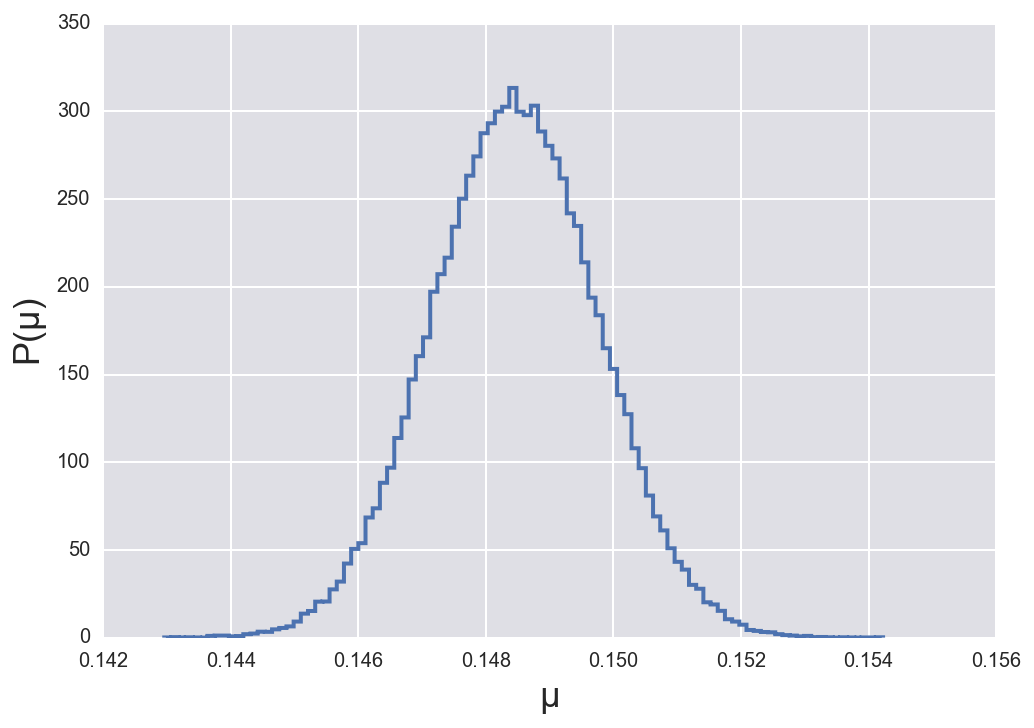

In [6]:
# Make draws
x_bar_samples = gaussian_draw(mu_wt, np.sqrt(var_wt), np.mean,
                              len(fly_wt), n_trials=100000)

# Plot the histogram
_ = plt.hist(x_bar_samples, normed=True, bins=100, histtype='step', lw=2)
plt.xlabel('µ')
plt.ylabel('P(µ)')

Note that I have labeled the $y$-axis as a $P(\mu)$.  This is **not** the probability distribution describing the values of the parameter $\mu$.  That would be a Bayesian probability distribution and make no sense in this frequentist context.  Rather, this is a probability distribution describing the values that we would estimate for $\mu$ if we did the experiment over and over and over again.  This is a frequentist probability.

As is often the case, it is more instructive to plot the CDF.

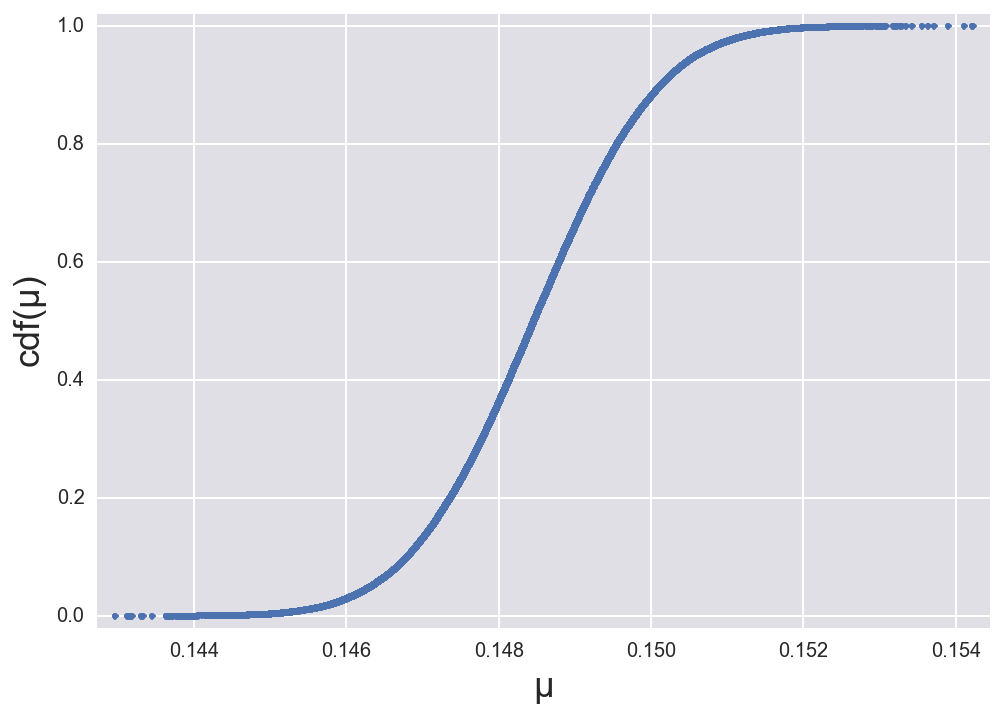

In [7]:
# Get x and y values for CDF
y = np.arange(len(x_bar_samples)) / len(x_bar_samples)
x = np.sort(x_bar_samples)
plt.plot(x, y, '.')
plt.margins(0.02)
plt.xlabel('µ')
plt.ylabel('cdf(µ)')

So, about 95% of the probability lies between $\mu = 0.146$ and $\mu = 0.151$.
We can now define our confidence interval as an interval containing the middle 68th% percentile of the $\mu$ estimates we could get if we did the experiment over and over again.

In [8]:
conf_range = np.percentile(x_bar_samples, (15.865, 84.135))
print(conf_range)

[ 0.14715287  0.14976168]


We often like symmetric confidence intervals, or those given by standard deviations of the Gaussian approximation of $P(\mu)$, so we can compute that directly from our samples.  We can show analytically that this is equivalent to the **standard error of the mean**, which is $\sqrt{\sigma^2/n}$.

In [9]:
print('Samnple s.e.m =', np.std(x_bar_samples))
print('s.e.m. =       ', np.sqrt(var_wt/len(fly_wt)))

Samnple s.e.m = 0.00130294093734
s.e.m. =        0.00130920426022


So, we can report

In [10]:
print('µ = {0:.4f} ± {1:.4f}'.format(mu_wt, np.std(x_bar_samples)))

µ = 0.1485 ± 0.0013


### Confidence interval for the variance
We can do the same thing with the variance.

σ 68% confidence interval: [ 0.01519236  0.01704606]


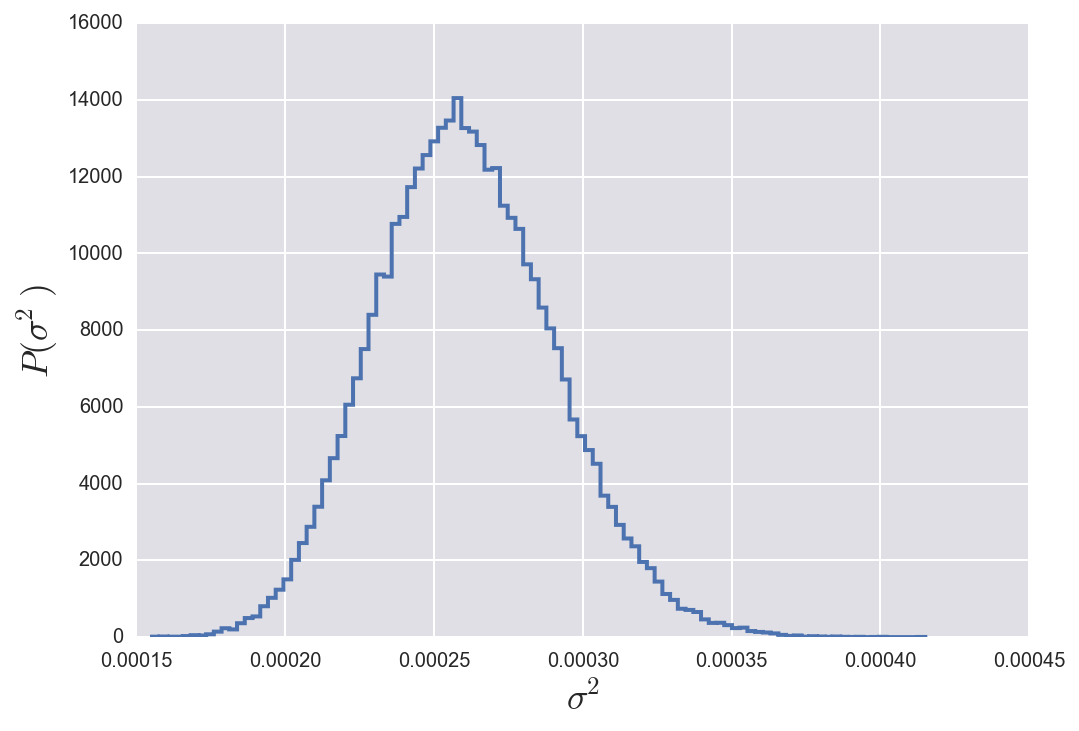

In [11]:
def gaussian_variance_estimator(x):
    return np.var(x, ddof=1)

# Make draws
var_samples = gaussian_draw(mu_wt, np.sqrt(var_wt), gaussian_variance_estimator,
                            len(fly_wt), n_trials=100000)

# Compute confidence interval
conf_range = np.percentile(var_samples, (15.865, 84.135))

# Print range of sigma
print('σ 68% confidence interval:', np.sqrt(conf_range))

# Plot histogram
_ = plt.hist(var_samples, bins=100, normed=True, histtype='step', lw=2)
plt.xlabel(r'$\sigma^2$')
plt.ylabel(r'$P(\sigma^2)$');

#### Speed with Numba
As a quick aside, we can do the sampling about three- or four-fold faster, but with a little less convenience in the function definitions, using just-in-time compilation with Numba.

In [12]:
@numba.jit(nopython=True)
def gaussian_draw_mean(mu, sigma, n, n_trials=1000):
    """
    Make draws from Gaussian distribution with mean mu and 
    standard deviation sigma and compute and tabulate a
    the estimate of the mean.
    """
    means = np.empty(n_trials)
    draws = np.empty(n)
    for i in range(n_trials):
        for j in range(n):
            draws[j] = np.random.normal(mu, sigma)
        means[i] = np.mean(draws)
    return means

# Functions for speed tests
def test_no_numba():
    return gaussian_draw(mu_wt, np.sqrt(var_wt), np.mean, len(fly_wt), 
                         n_trials=1000)

def test_numba():
    return gaussian_draw_mean(mu_wt, np.sqrt(var_wt), len(fly_wt), n_trials=1000)

# Do speed tests
print('Non-numba:')
%timeit test_no_numba()

print('\n\nWith numba:')
%timeit test_numba()

Non-numba:
100 loops, best of 3: 16.3 ms per loop


With numba:
The slowest run took 46.02 times longer than the fastest. This could mean that an intermediate result is being cached 
100 loops, best of 3: 4.33 ms per loop


## Estimation from regression
We saw how to estimate parameters from repeated measurements, but how about regressions?  The analysis of which estimators are unbiased is involved for general (nonlinear) models.  For present purposes, we will assume that the **least squares estimate** is what we are after.  In this case, the estimate is the set of parameters that minimize the sum of the squares of the residuals, or:

\begin{align}
\mathbf{a}_\text{est} = \arg \min_\mathbf{a} (y_i - y(x_i;\mathbf{a})),
\end{align}

where $y(x;\mathbf{a})$ is our "model 2" describing what we expect from our data.  Note that there are no priors here, so this problem is equivalent to finding the MAP where the priors are all uniform in the Bayesian context.  We have already learned how to do this.

Let's do it with the mitotic spindle data.  As a reminder, we wish to fit the data to

\begin{align}
l(d;\theta,\gamma) = \frac{\gamma d}{\left(1 + \left(\frac{\gamma d}{\theta}\right)^3\right)^{1/3}}.
\end{align}

We can write a function to find the estimators of the parameters $\theta$ and $\gamma$ using functions we wrote in [Tutorial 3a](http://bebi103.caltech.edu/2015/tutorials/t3a_regression.html).

In [13]:
def spindle_length(p, d):
    """
    Theoretical model for spindle length
    """
    theta, gamma = p
    return gamma * d / np.cbrt(1 + (gamma * d / theta)**3)


def resid(p, d, ell):
    """
    Residuals for spindle length model.
    """
    return ell - spindle_length(p, d)


def fit_spindle_model(d, ell, theta_0=40, gamma_0=0.6):
    """
    Fit's the model for spindle length to data to fine 
    theta and gamma.
    """

    # Initial guess
    p0 = np.array([theta_0, gamma_0])

    # Extra arguments as a tuple
    args = (d, ell)

    # Do the fit
    popt, _ = scipy.optimize.leastsq(resid, p0, args=args)

    return popt

# Do the fit
theta, gamma = fit_spindle_model(df_good['Droplet Diameter (um)'],
                                 df_good['Spindle Length (um)'])

# Print result
print('theta =', theta, 'µm\ngamma =', gamma)

theta = 38.2468142384 µm
gamma = 0.860104629145


Now, how do we get our confidence interval?  This is trickier.  What probability distribution do we get samples out of to then compute estimates for $\theta$ and $\gamma$, to then use to get confidence intervals?  We do not know.

### Bootstrap estimates
The idea behind the bootstrap, invented in 1979 by Brad Efron, is to instead sample out of a distribution that is a proxy for the distribution behind the data.

Let $P(l\;d,\theta,\gamma)$ be the distribution describing $l$.  As an approximation to it, based entirely on the data, we will take

\begin{align}
P(l\;d,\theta,\gamma) \approx P^*(l\;d,\theta,\gamma) = \frac{1}{n}\sum_i\delta(l(d;\theta,\gamma)-l_i),
\end{align}

where $\delta(x)$ denotes the Dirac delta function.  So, we approximate the distribution as a discrete set of points that we can draw from.  So, to do our computational repeat of the experiment, we draw new data out of the distribution $P^*(l\;d,\theta,\gamma)$ and perform a least squares fit on these newly drawn data.  We do this over and over again.  This is called **bootstrapping**.

Note: we are drawing out of $P^*(l;d,\theta,\gamma)$, we we make our draws *with replacement*.  We can use `np.random.choice()` for this.  First, we'll write a function to do it for general $x,y$ data with a pre-written function to perform the linear regression (in our case, this is `fit_spindle_model()`).

In [14]:
def bootstrap_regression(x, y, fit_fun, n_params, args=(), n_trials=1000):
    """
    Get bootstrap samples of parameters describing x, y data
    that have parameters fit via least squares using fit_fun().
    
    To avoid indexing issues, x and y must be NumPy arrays.
    """
    # Array to hold samples
    samples = np.empty((n_params, n_trials))

    # Indices that we use for resampling
    inds_to_choose = np.arange(len(x), dtype=int)
    
    for i in range(n_trials):
        # Choose data points with replacements
        inds = np.random.choice(inds_to_choose, len(x), replace=True)
        x_resample = x[inds]
        y_resample = y[inds]

        # Perform least squares with resampled data
        samples[:,i] = fit_fun(x_resample, y_resample, *args)

    return samples

Now that we have our function, we can do bootstrap samples for the spindle model.  Note that we need to pass our initial guesses for `theta` and `gamma` into `fit_spindle_model()` using the `args` kwarg of `bootstrap_regression()`.

In [15]:
theta_samples, gamma_samples = bootstrap_regression(
        df_good['Droplet Diameter (um)'].values, 
        df_good['Spindle Length (um)'].values,
        fit_spindle_model, 2, args=(40, 0.6), n_trials=10000)        

Now, we can use these samples to compute $P(\theta)$ and $P(\gamma)$.  Remember, there are **not** probability distributions of the parameter values.  They are probability distributions describing what we would estimate the parameter values to be if we repeated the experiment over and over again.

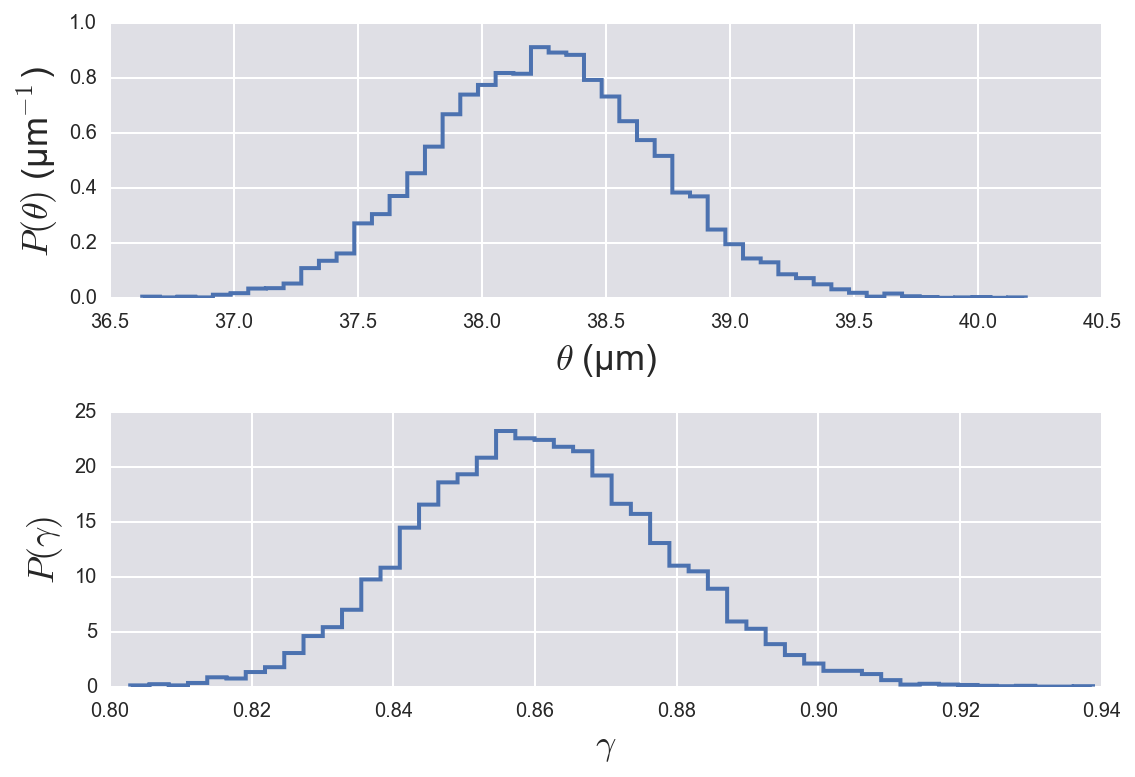

In [16]:
# Make histograms
fig, ax = plt.subplots(2, 1)

_ = ax[0].hist(theta_samples, bins=50, histtype='step', lw=2, normed=True)
ax[0].set_xlabel(r'$\theta$ (µm)')
ax[0].set_ylabel(r'$P(\theta)$ (µm$^{-1}$)')

_ = ax[1].hist(gamma_samples, bins=50, histtype='step', lw=2, normed=True)
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel(r'$P(\gamma)$')

plt.tight_layout()

We'll report the confidence intervals as the middle 95th percentile.

In [17]:
theta_low, theta_high = np.percentile(theta_samples, (2.5, 97.5))
gamma_low, gamma_high = np.percentile(gamma_samples, (2.5, 97.5))

print("""
theta 95% confidence interval: [{0:.2f}, {1:.2f}]
gamma 95% confidence interval: [{2:.3f}, {3:.3f}]
""".format(theta_low, theta_high, gamma_low, gamma_high))


theta 95% confidence interval: [37.39, 39.16]
gamma 95% confidence interval: [0.828, 0.896]



We can make an interesting plot from our bootstrap samples.  We can plot many of the lines we get form our bootstrap regressions with transparency, and we can get a feel for how the fit line might move as we repeat the experiment over and over again.

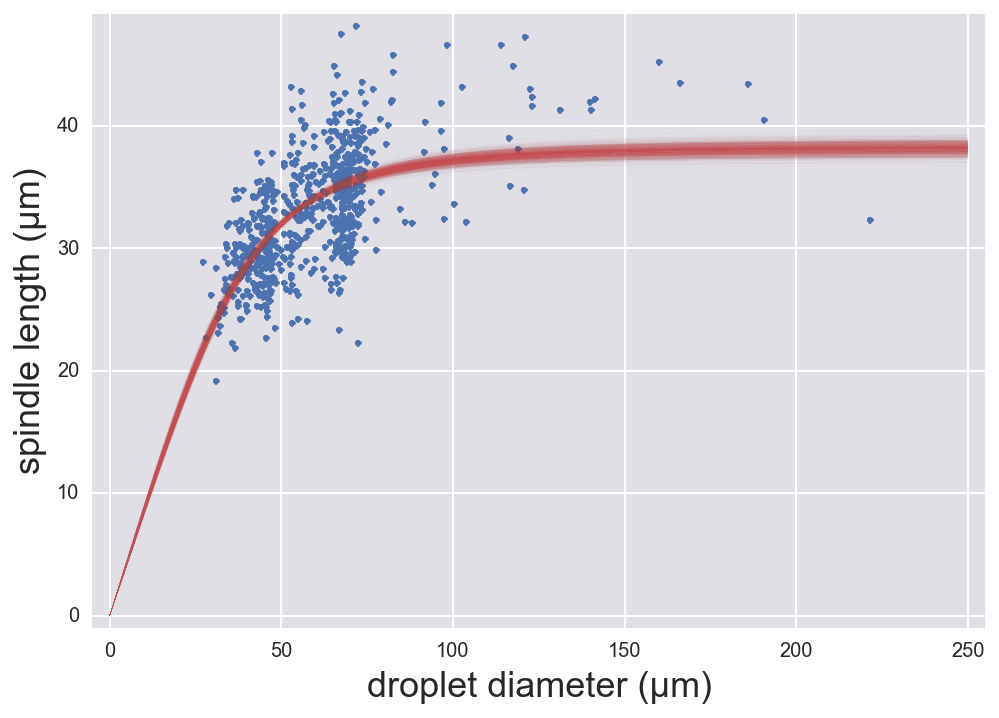

In [18]:
# Make smooth curves out of every 10th sample
d_smooth = np.linspace(0, 250, 200)
thetas = theta_samples[::10]
gammas = gamma_samples[::10]
ell_smooth = np.empty((len(d_smooth), len(thetas)))
for i, theta in enumerate(thetas):
    ell_smooth[:,i] = spindle_length((theta, gammas[i]), d_smooth)
                    
# Make plot
plt.plot(df_good['Droplet Diameter (um)'], df_good['Spindle Length (um)'], '.')
plt.plot(d_smooth, ell_smooth, '-', lw=0.1, color=sns.color_palette()[2], 
         alpha=0.1);
plt.margins(0.02)
plt.xlabel('droplet diameter (µm)')
plt.ylabel('spindle length (µm)')

## Bootstrap estimates of other statistics
We can use bootstrapping in many contexts.  We just compute the statistic of interest from the data multiple times.  For example, before, we got an estimate of the mean Dorsal gradient (and its variance) by sampling out of a Gaussian distribution.  This is sometimes called **parametric bootstrap**, in that we parametrized the data with a model, specifically a Gaussian one.  We can get an estimate of the sample mean and its confidence interval as a nonparametric quantity using bootstrap (or specifically nonparametric bootstrap).

In [19]:
def bootstrap_repeated_measurements(x, stat_fun, args=(), n_trials=1000):
    """
    Get bootstrap samples of a statistic from repeated
    measurements `x`.  `stat_fun` must be of the form
    stat_fun(x, *args).
    """
    # Indices that we use for resampling
    inds_to_choose = np.arange(len(x), dtype=int)   
    
    # Samples to save
    samples = np.empty(n_trials)
    
    return np.array(
        [stat_fun(x[np.random.choice(inds_to_choose, len(x), replace=True)])
                   for _ in range(n_trials)])

Now we'll call this function with `stat_fun = np.mean`.

In [20]:
mean_samples = bootstrap_repeated_measurements(fly_wt, np.mean, n_trials=100000)

Let's plot the histogram.

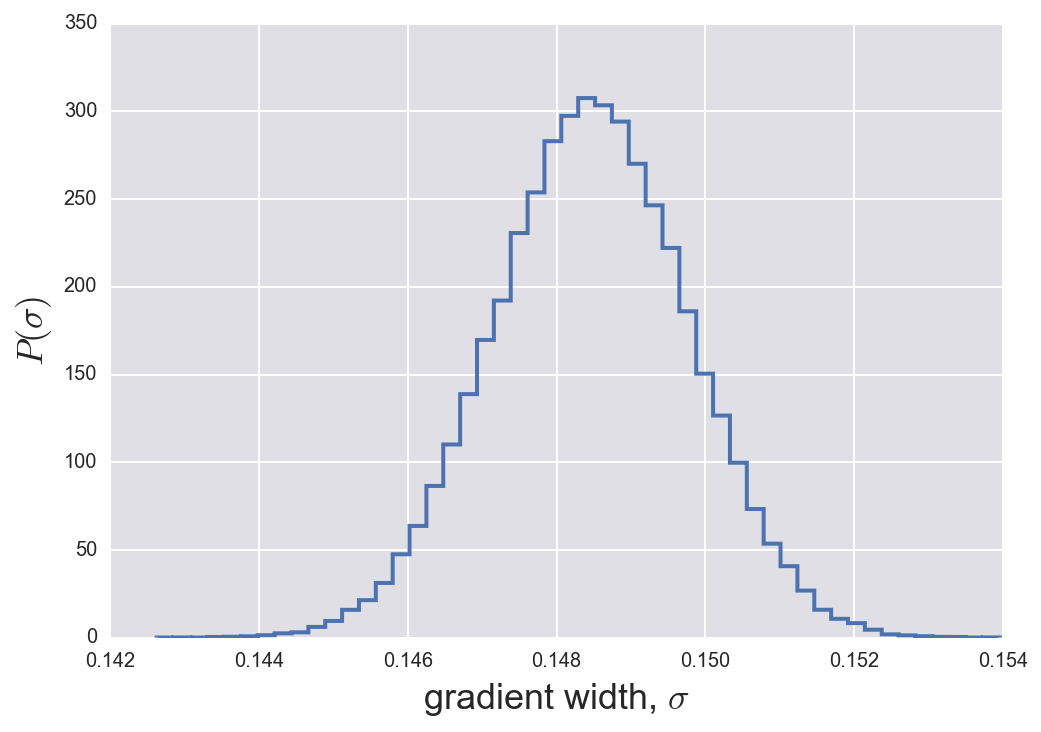

In [21]:
_ = plt.hist(mean_samples, bins=50, normed=True, histtype='step', lw=2)
plt.xlabel(r'gradient width, $\sigma$')
plt.ylabel(r'$P(\sigma)$')

Assuming the distribution of the mean is approximately Gaussian and it makes sense to report the confidence interval using the standard deviation, we get:

In [22]:
print("""
mean gradient width = {0:.4f} ± {1:.4f}
""".format(mean_samples.mean(), mean_samples.std()))


mean gradient width = 0.1485 ± 0.0013



This is the same result we got with parametric estimation before, a testament to the Gaussianity of the data.  It also helps that we have many data.

An added benefit of the bootstrap is that we can also compute probability distributions describing estimates of other statistics, such as the median.  (*Again*, and you're probably getting sick of this, we're talking about frequentist probability here.  This is the probability that you would observe a value of the median in repeated experiments.)

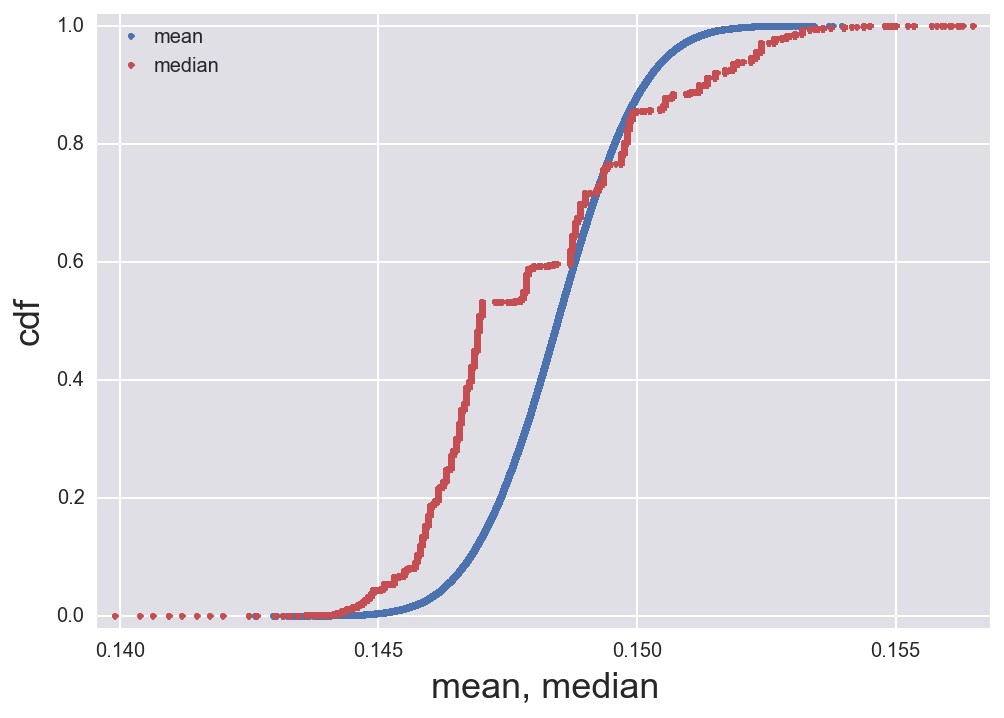

In [23]:
# Do bootstrap samples of the median
median_samples = bootstrap_repeated_measurements(fly_wt, np.median, 
                                                 n_trials=100000)

# Plot cumulative histrograms of mean
y = np.arange(len(mean_samples)) / len(mean_samples)
x = np.sort(mean_samples)
plt.plot(x, y, '.', label='mean')

# Plot cumulative histograms of median
y = np.arange(len(median_samples)) / len(median_samples)
x = np.sort(median_samples)
plt.plot(x, y, '.', color=sns.color_palette()[2], label='median')


plt.margins(0.02)
plt.xlabel('mean, median')
plt.ylabel('cdf')
plt.legend(loc='upper left')

The median has a higher probability of being smaller than the mean.  This is due to a few high outliers in the data which skews the mean rightward, but not the median.